# Deep Learning
## Assignment 1

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the notMNIST dataset to be used with python experiments. This dataset is designed to look like the classic MNIST dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [4]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
import math
import string
import time
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from IPython.display import display, Image
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labeled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [ ]:
url = 'https://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = '.' # Change to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
    """A hook to report the progress of a download. This is mostly intended for users with 
    slow internet connections. report every 5% change in download progress
    """
    global last_percent_reported
    percent = int(count*blockSize*100/totalSize)
    
    if last_percent_reported != percent:
        if percent%5==0:
            sys.stdout.write("%s%%" % percent)
            sys.stdout.flush()
        else:
            sys.stdout.write(".")
            sys.stdout.flush()
        
        last_percent_reported = percent

def maybe_download(filename, expected_bytes, force=False):
    """Download a file if not present, and make sure it's the right size."""
    dest_filename = os.path.join(data_root, filename)
    if force or not os.path.exists(dest_filename):
        print('Attempting to download:', filename)
        filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
        print('\nDownload Complete!')
    statinfo = os.stat(dest_filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', dest_filename)
    else:
        raise Exception(
        'Failed to verify'+dest_filename+'. Can you get to it with a browser?')
    return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz',247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Extract the dataset from the compressed .tar.gz file. This should give you a set of directories, labeled A through J.

In [ ]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
    root = os.path.splitext(os.path.splitext(filename)[0])[0]
    if os.path.isdir(root) and not force:
        print('%s already present - Skipping extraction of %s' % (root, filename))
    else:
        print('Extracting data for %s. This may take a while. Please wait.' % root)
        tar = tarfile.open(filename)
        sys.stdout.flush()
        tar.extractall(data_root)
        tar.close()
    data_folders = [
        os.path.join(root,d) for d in sorted(os.listdir(root))
        if os.path.isdir(os.path.join(root,d))]
    if len(data_folders) != num_classes:
        raise Exception(
        'Expected %d folders, one per class. Found %d instead.' %(num_classes, len(data_folders)))
    print(data_folders)
    return data_folders

train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)


In [ ]:
train_folders

## Problem 1
Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road.

A few images might not be readable, we'll just skip them.


In [ ]:
image_size = 28 # pixel width and height.
pixel_depth = 255.0 # Number if levels per pixels

def load_letter(folder, min_num_images):
    """Load the data for a single letter label."""
    image_files = os.listdir(folder)
    dataset = np.ndarray(shape=(len(image_files),image_size, image_size), dtype=np.float32)
    print(folder)
    num_images = 0
    for image in image_files:
        image_file = os.path.join(folder, image) # get full path of file
        try:
            image_data =(imageio.imread(image_file).astype(float) - pixel_depth / 2) / pixel_depth # normalize the image
            if image_data.shape != (image_size, image_size):
                raise Exception('Unexpected image shape: %s' % str(image_data.shape))
            dataset[num_images, :, :] = image_data
            num_images = num_images + 1
        except (IOError, ValueError) as e:
            print('Could not read', image_file, ':', e, '-it\'s ok, skipping.')
    dataset = dataset[0:num_images,:,:]
    if num_images < min_num_images:
        raise Exception('Many fewer images than expected: %d < %d' % (num_images, min_num_images))
    print('Full dataset tensor:', dataset.shape)
    print('Mean:', np.mean(dataset))
    print('Standard deviation:', np.std(dataset))
    return dataset

def maybe_pickle(data_folders, min_num_images_per_class, force=False):
    dataset_names = []
    for folder in data_folders:
        set_filename = folder + '.pickle'
        dataset_names.append(set_filename)
        if os.path.exists(set_filename) and not force:
            # You may override by setting force=True
            print('%s already present - Skipping pickling.' % set_filename)
        else:
            print('Pickling %s.' % set_filename)
            dataset = load_letter(folder, min_num_images_per_class)
            try:
                    with open(set_filename, 'wb') as f:
                        pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
            except Exception as e:
                print('Unable to save data to', set_filename, ':', e)
    return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)


## Problem 2

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

In [ ]:
with open(train_datasets[np.random.randint(len(train_datasets))], 'rb') as f:
    letter_set = pickle.load(f)
    plt.imshow(letter_set[np.random.randint(len(letter_set))])

## Problem 3

Another check: we expect the data to be balanced across classes. Verify that.

In [ ]:
dataset_shape = []
for label,file in enumerate(train_datasets):
    try: 
        with open(file, 'rb') as f:
            letter_set = pickle.load(f)
            dataset_shape.append({label,letter_set.shape})
    except Exception as e:
        print('Unable to process data from', file,':',e)
        raise
#     print(label, file)
print(dataset_shape)

Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune train_size as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [ ]:
def make_arrays(nb_rows, img_size):
    """Create dataset and labels array"""
    if nb_rows:
        dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
        labels = np.ndarray(nb_rows, dtype=np.float32)
    else:
        dataset, labels = None, None
    return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
    num_classes = len(pickle_files)
    valid_dataset, valid_labels = make_arrays(valid_size, image_size)
    train_dataset, train_labels = make_arrays(train_size, image_size)
    vsize_per_class = valid_size // num_classes
    tsize_per_class = train_size // num_classes
    
    start_v, start_t = 0, 0
    end_v, end_t = vsize_per_class, tsize_per_class 
    end_l = vsize_per_class + tsize_per_class # why?????
    
    for label, pickle_file in enumerate(pickle_files):
        try: 
            with open(pickle_file, 'rb') as f:
                letter_set = pickle.load(f)
                # let's shuffle the letters to have random validation and training set
                np.random.shuffle(letter_set)
                if valid_dataset is not None:
                    valid_letter = letter_set[:vsize_per_class, :,:]
                    valid_dataset[start_v:end_v, :,:] = valid_letter
                    valid_labels[start_v:end_v] = label
                    start_v += vsize_per_class
                    end_v += vsize_per_class
                    
                train_letter = letter_set[vsize_per_class:end_l,:,:]
                train_dataset[start_t:end_t, :,:] = train_letter
                train_labels[start_t:end_t] = label
                start_t += tsize_per_class
                end_t += tsize_per_class
        except Exception as e:
            print('Unable to process data from', pickle_file,':',e)
            raise
    return valid_dataset, valid_labels, train_dataset, train_labels

train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [ ]:
def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation,:,:]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

## Problem 4

Convince yourself that the data is still good after shuffling!

Finally, let's save the data for later reuse:

In [ ]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
    f = open(pickle_file, 'wb')
    save = {
        'train_dataset': train_dataset,
        'train_labels': train_labels,
        'valid_dataset': valid_dataset,
        'valid_labels': valid_labels,
        'test_dataset': test_dataset,
        'test_labels': test_labels,
    }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

In [6]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800470


## Problem 5

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it. Measure how much overlap there is between training, validation and test samples.

Optional questions:
* What about near duplicates between datasets? (images that are almost identical)
* Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.



In [10]:
dataset_filename = 'notMNIST.pickle'
def load_dataset(dataset_name):
    if os.path.exists(dataset_filename):
        try:
            with open(dataset_filename, 'rb') as f:
                dataset = pickle.load(f)
                print('Loaded %s in dataset' % dataset_filename)
        except Exception as e:
            print('Error:', e)
    else:
        print('Unable to find', dataset_filename)
        dataset = None
    return dataset
dataset = load_dataset(dataset_filename)
train_dataset = dataset['train_dataset']
valid_dataset = dataset['valid_dataset']
test_dataset = dataset['test_dataset']

Loaded notMNIST.pickle in dataset


In [12]:
def check_overlaps(images1, images2):
    images1.flags.writeable = False
    images2.flags.writeable = False
    start = time.clock()
    hash1 = set([hash(image1.tobytes()) for image1 in images1])
    hash2 = set([hash(image2.tobytes()) for image2 in images2])
    all_overlaps = set.intersection(hash1, hash2)
    return all_overlaps, time.clock()-start

r, execTime = check_overlaps(train_dataset, test_dataset)
print('Number of overlaps between training and test sets: {}. Execution time: {}.'.format(len(r), execTime))
r, execTime = check_overlaps(train_dataset, valid_dataset)
print('Number of overlaps between training and validation sets: {}. Execution time: {}.'.format(len(r), execTime))
r, execTime = check_overlaps(valid_dataset, test_dataset)
print('Number of overlaps between validation and test sets: {}. Execution time: {}.'.format(len(r), execTime))

Number of overlaps between training and test sets: 1153. Execution time: 0.41601100000000013.
Number of overlaps between training and validation sets: 953. Execution time: 0.4030510000000005.
Number of overlaps between validation and test sets: 55. Execution time: 0.037519999999999776.


## Problem 6

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

In [24]:
samples = 10000
train_dataset, train_labels = dataset['train_dataset'][:samples], dataset['train_labels'][:samples]
valid_dataset, valid_labels = dataset['valid_dataset'][:samples],dataset['valid_labels'][:samples]
test_dataset, test_labels = dataset['test_dataset'][:samples], dataset['test_labels'][:samples]
sample, img_width, img_height = train_dataset.shape
label_size = train_labels.shape
print(train_dataset.shape, train_labels.shape)

(10000, 28, 28) (10000,)


In [25]:
# reshape data for sklearn library
train_dataset_reshape = train_dataset.reshape((samples, img_width*img_height))
train_labels_reshape = train_labels.reshape((samples, -1))
valid_dataset_reshape = valid_dataset.reshape((samples,img_width*img_height))
valid_labels_reshape = valid_labels.reshape((samples, -1))
test_dataset_reshape = test_dataset.reshape((samples, img_width*img_height))
test_labels_reshape = test_labels.reshape((samples, -1))

In [26]:
# predict
classifier = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42, verbose=1, max_iter=1000, n_jobs=-1)
classifier.fit(train_dataset_reshape, train_labels_reshape)
valid_score = classifier.score(valid_dataset_reshape, valid_labels_reshape)
test_score = classifier.score(test_dataset_reshape, test_labels_reshape)

/home/othniel/anaconda3/envs/dp/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   23.8s finished


In [27]:
# test prediction
predictions = classifier.predict(valid_dataset_reshape)
labels = valid_labels_reshape.reshape(-1)

In [28]:
train_dataset.shape

(10000, 28, 28)

Final RMSE (on test data): 1.95
Accuracy (on test data): 78.36
Score (on validation data): 0.78
Score (on test data): 0.86
Classification report for classifier LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='multinomial',
          n_jobs=-1, penalty='l2', random_state=42, solver='lbfgs',
          tol=0.0001, verbose=1, warm_start=False):
              precision    recall  f1-score   support

           a       0.81      0.80      0.81      1000
           b       0.83      0.74      0.78      1000
           c       0.80      0.84      0.82      1000
           d       0.78      0.79      0.79      1000
           e       0.76      0.74      0.75      1000
           f       0.79      0.83      0.81      1000
           g       0.80      0.77      0.78      1000
           h       0.78      0.77      0.78      1000
           i       0.70      0.76      0.73      1000
           j       0.79      

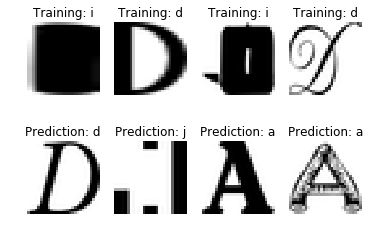

In [29]:
rmse = math.sqrt(metrics.mean_squared_error(predictions,labels))
confusion_matrix = metrics.confusion_matrix(labels, predictions)

accuracy = (predictions == labels).sum()*100.0/samples
print('Final RMSE (on test data): %0.2f' % rmse)
print('Accuracy (on test data): %0.2f' % accuracy)
print('Score (on validation data): %.2f' % valid_score)
print('Score (on test data): %.2f' % test_score)

print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(labels, predictions, target_names = list(string.ascii_lowercase)[:10])))
print("Confusion matrix:\n%s" % confusion_matrix)

letter_dict = dict(zip(string.ascii_lowercase, range(26)))
images_and_labels = list(zip(train_dataset, train_labels))
max_image = 4
for index, (image, label) in enumerate(images_and_labels[:max_image]):
    plt.subplot(2,max_image,index+1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Training: %s' % list(letter_dict.keys())[list(letter_dict.values()).index(label)]) 
    
images_and_labels = list(zip(valid_dataset, predictions))
for index, (image, label) in enumerate(images_and_labels[:max_image]):
    plt.subplot(2,max_image,index+max_image+1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Prediction: %s' % list(letter_dict.keys())[list(letter_dict.values()).index(label)])

## Optional question: 
Train an off-the-shelf model on all the data!

/home/othniel/anaconda3/envs/dp/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  7.6min finished


Final RMSE (on test data): 1.73
Score (on validation data): 0.83
Score (on test data): 0.90
Classification report for classifier LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='multinomial',
          n_jobs=-1, penalty='l2', random_state=42, solver='lbfgs',
          tol=0.0001, verbose=1, warm_start=False):
              precision    recall  f1-score   support

           a       0.86      0.84      0.85      1000
           b       0.84      0.81      0.82      1000
           c       0.86      0.87      0.87      1000
           d       0.85      0.85      0.85      1000
           e       0.83      0.78      0.80      1000
           f       0.84      0.88      0.86      1000
           g       0.84      0.83      0.83      1000
           h       0.82      0.83      0.82      1000
           i       0.76      0.79      0.77      1000
           j       0.83      0.83      0.83      1000

   mi

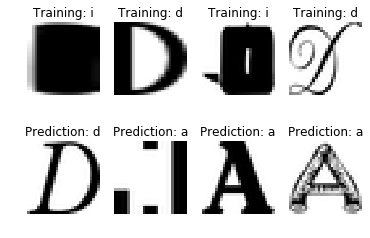

In [33]:
train_dataset = dataset['train_dataset']
valid_dataset = dataset['valid_dataset']
test_dataset = dataset['test_dataset']
train_labels = dataset['train_labels']
valid_labels = dataset['valid_labels']
test_labels = dataset['test_labels']



# reshape data for sklearn library
samples, img_width, img_height = train_dataset.shape
label_size = train_labels.shape
train_dataset_reshape = train_dataset.reshape((samples, img_width*img_height))
train_labels_reshape = train_labels.reshape((samples, -1))
samples, img_width, img_height = valid_dataset.shape
label_size = train_labels.shape
valid_dataset_reshape = valid_dataset.reshape((samples,img_width*img_height))
valid_labels_reshape = valid_labels.reshape((samples, -1))
samples, img_width, img_height = test_dataset.shape
label_size = train_labels.shape
test_dataset_reshape = test_dataset.reshape((samples, img_width*img_height))
test_labels_reshape = test_labels.reshape((samples, -1))

# predict
classifier = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42, verbose=1, max_iter=1000, n_jobs=-1)
classifier.fit(train_dataset_reshape, train_labels_reshape)
valid_score = classifier.score(valid_dataset_reshape, valid_labels_reshape)
test_score = classifier.score(test_dataset_reshape, test_labels_reshape)

# test prediction
predictions = classifier.predict(valid_dataset_reshape)
labels = valid_labels_reshape.reshape(-1)

rmse = math.sqrt(metrics.mean_squared_error(predictions,labels))
confusion_matrix = metrics.confusion_matrix(labels, predictions)

print('Final RMSE (on test data): %0.2f' % rmse)
print('Score (on validation data): %.2f' % valid_score)
print('Score (on test data): %.2f' % test_score)

print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(labels, predictions, target_names = list(string.ascii_lowercase)[:10])))
print("Confusion matrix:\n%s" % confusion_matrix)

letter_dict = dict(zip(string.ascii_lowercase, range(26)))
images_and_labels = list(zip(train_dataset, train_labels))
max_image = 4
for index, (image, label) in enumerate(images_and_labels[:max_image]):
    plt.subplot(2,max_image,index+1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Training: %s' % list(letter_dict.keys())[list(letter_dict.values()).index(label)]) 
    
images_and_labels = list(zip(valid_dataset, predictions))
for index, (image, label) in enumerate(images_and_labels[:max_image]):
    plt.subplot(2,max_image,index+max_image+1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Prediction: %s' % list(letter_dict.keys())[list(letter_dict.values()).index(label)])